# 패키지

In [ ]:
# !pip install seaborn
# !pip install tqdm
# !pip install -U scikit-learn
# !pip install emoji
# !pip install pyarrow
# !pip install fastparquet
# !pip install squarify
# !pip install wordcloud
# !pip install textblob

In [1]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import squarify
from tqdm import tqdm, tqdm_pandas
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma, Hannanum
from collections import Counter
from emoji import core
from wordcloud import WordCloud
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Kkma = Kkma()
hannanum = Hannanum()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


-----------------------
# 함수

In [2]:
# dataframe에 있는 contents(본문)에 키워드 존재 여부 칼럼만들기
def keyword_search(df, key1):

    key1_list = []
    key2_list = []

    for i in df['contents']:
        if '아이스크림' in i:
            key1_list.append(True)

        else:
            key1_list.append(False)

    df[key1] = key1_list
    return df

# 전처리 함수 1 : point_reduce
# 점이 여러개 찍혀있는 것을 한개로 바꿈

def point_reduce(sentence):
    while True:
        try:
            if '..' in sentence:
                sentence = sentence.replace('..','.')
            
            else:
                sentence = sentence.replace('.','. ') # 온점 뒤에 space 넣어뒀음. 불필요시 제거.
                if '  ' in sentence:
                    sentence = sentence.replace('  ',' ')
                    # print(sentence)
                    return sentence
                    break
                else:
                    return sentence
        except:
            return sentence
        
        # if '  ' not in sentence:
        #     break

# 문장 단위로 끊기
def classify_sentence(sentence):
    sentence_list = sentence.split('. ')
    if ' ' in sentence_list:
        sentence_list.remove(' ')
        return sentence_list

    else:
        return sentence_list

# dummy 없애기 (밀크티 관련만 남기기)

def search_milkT(text):
    if "밀크티" in text:
        return True

    elif "밀크t" in text.lower():
        return True
            
    elif "milkT" in text.lower():
        return True
    
    elif "ㅁㅋㅌ" in text:
        return True

    # elif "학습" in text:
    #     return True

    else:
        return False

# 광고 여부 확인하기

def check_ad(text):
    if '광고' in text:
        return True
    
    elif '추천인' in text:
        return True

    elif '서포터' in text:
        return True

    else:
        return False

# 주어 찾기 함수

def subject_extraction(text):
    
    # 형태소 분석
    pos = Kkma.pos(text)

    # 주어 추출
    for i in range(len(pos)):
        if pos[i][1] == 'NNG':  # 명사
            if i == 0 or (i > 0 and pos[i-1][1] != 'NNG'):  # 주어는 문장 첫 단어이거나 앞 단어가 조사가 아닌 경우
                return pos[i][0]
                break

# 키워드가 주어인 본문 정리하기
## keword에서 다음 keyword 까지의 text 추출


def gather_sentence(text, key1, key2):
    
    text_list = text.split('.') # 문장 단위 : "."

    while ' ' in text_list: # '' 안에 text가 들어있지 않으면 error가 발생함을 방지
        text_list.remove(' ')

    key1_paragraph = []
    key2_paragraph = []
    for i in range(len(text_list)):
        if subject_extraction(text_list[i]) == key1:
            plus_num = 1
            # milk_para.append(text_list[i])
            sentence = text_list[i]
            # print(f'{key1}파트 {i}번째 진행중')
            while i+plus_num < len(text_list):
                if subject_extraction(text_list[i+plus_num]) == key1 or subject_extraction(text_list[i+plus_num]) == key2:
                    # print(f'!! 스캔 {key1}파트 종료')
                    break
                
                else:
                    # milk_para.append(text_list[i+plus_num])
                    if i+plus_num > len(text_list):
                        # print(f'!! 스캔 {key1}파트 종료')
                        break
                    else:
                        sentence = sentence + '' + text_list[i+plus_num]
                        plus_num += 1
                        # print(f'!! 스캔 {key1}파트 {i+plus_num}번째 진행중')

            key1_paragraph.append(sentence)

        else:
            pass

        if subject_extraction(text_list[i]) == key2:
            plus_num = 1
            # milk_para.append(text_list[i])
            sentence = text_list[i]
            # print(f'{key2}파트 {i}번째 진행중')
            while i+plus_num < len(text_list):
                if subject_extraction(text_list[i+plus_num]) == key1 or subject_extraction(text_list[i+plus_num]) == key2:
                    break
                
                else:
                    # milk_para.append(text_list[i+plus_num])
                    sentence = sentence + '' + text_list[i+plus_num]
                    plus_num += 1

            key2_paragraph.append(sentence)

        else:
            pass

    if key1_paragraph == []:
        for i in range(len(text_list)):
            pos_list = Kkma.pos(text_list[i])
            if (key1, 'NNG') in pos_list:
                key1_paragraph.append(text_list[i])

    if key2_paragraph == []:
        for i in range(len(text_list)):
            pos_list = Kkma.pos(text_list[i])
            if (key2, 'NNG') in pos_list:
                key2_paragraph.append(text_list[i])
    else:
        pass
    
    return {key1 : key1_paragraph, key2 : key2_paragraph}

# 명사, 동사 추출

def extract_func(dict):
    key1 = list(dict.keys())[0]
    key2 = list(dict.keys())[1]
    key1_list = []
    key2_list = []

    for i in range(len(dict[key1])):
        pos = Kkma.pos(dict[key1][i])
        for j in pos:
            if j[1] == 'VA': #동사
                if j[1] not in stop_words:
                    key1_list.append(j[0]+'다')
            if j[1] == 'NNG':
                if j[1] not in stop_words:
                    key1_list.append(j[0])

    for i in range(len(dict[key2])):
        pos = Kkma.pos(dict[key2][i])
        for j in pos:
            if j[1] == 'VA': #동사
                if j[1] not in stop_words:
                    key2_list.append(j[0]+'다')
            if j[1] == 'NNG':
                if j[1] not in stop_words:
                    key2_list.append(j[0])

    frequncy_dict = {key1 : key1_list, key2 : key2_list}

    return frequncy_dict

-------------------------
# 코드

In [ ]:
    # dataframe 불러오기 및 전처리
df_mg = pd.DataFrame(columns=['contents', 'recommend', '아이스크림', '엘리하이', 'keyword_dict']) # 'topic'

for i in tqdm(range(1,6)):
        # csv파일 불러오기
        df = pd.read_parquet(f'./data/crwaling_data{i}.parquet') 
        df.rename(columns={'text' : 'contents'}, inplace=True)
        # 크롤링 실패한 raw, 불필요한 column 삭제
        col_list = list(df.columns)
        col_list.remove('contents')
        df.drop(col_list, axis=1, inplace=True)

        # 정규식
        df.contents = df.contents.apply(lambda x : re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\n★▲;]','', x))
        df.contents = df.contents.apply(lambda x : re.sub('\W. ','',x))

        # 이모티콘 제거
        df.contents = df.contents.apply(lambda x : core.replace_emoji(x, replace=''))

        # 문장단위로 분리
        df['contents'] = df['contents'].apply(lambda x: point_reduce(x))
        df['contents_list'] = df['contents'].apply(lambda x: classify_sentence(x))

        # dummy 없애기 2 (학습과 관련된 데이터만 남기기 ('학습', '선생'))

        df['Check_milkT'] = df['contents'].apply(lambda x : search_milkT(x))
        df['check_test'] = df['contents'].apply(lambda x : '학습' in x and '선생' in x)

        # df.Check_milkT.value_counts()
        # df['check_test'].value_counts()

        df = df[df['check_test'] == True]
        df = df[df['Check_milkT'] == True]

        df['recommend'] = df['contents'].apply(lambda x : check_ad(x))
        df = df.drop(['Check_milkT', 'check_test'], axis=1)
        df.reset_index(drop=True, inplace=True)

        df.drop('contents_list', axis=1, inplace=True)
        df = keyword_search(df, '아이스크림')
        df = keyword_search(df, '엘리하이')   

        df_mg = pd.merge(df_mg, df, how='outer')

In [3]:
stop_words = ['아이', '맘', '거', '저', '저희', '것', '학모', '감사', '게', '때', '애', '원', '제', '개', '일', '듯', '만', '번', '데', '분', '건', '정도', '달', '정보', '이번', '부탁', '걸로', '후', '나', '부분', '걸', '저흰', '답변', '마음', '뼈', '건가요', '오늘', '왜', '시', '꺼', '친구', '마미', '때문', '하루', '명', '돈', '해요', '이', '가요', '기', '지금', '건가요', '반', '주세요', '편', '외', '소개', '입니다', '곳', '이거', '뭐', '땐', '건지', '그거', '점', '땐', '미', '풀', '대', '안', '눈', '공주', '사', '오', '백', '후', '나']

In [ ]:
df_mg

In [ ]:
# # key1 = '홈런'
# # key2 = input('find keyword')
# df_mg['keyword_dict'] = df_mg['contents'].apply(lambda x : gather_sentence(x, '밀크', '홈런'))

# df_mg['keyword_dict'] = [gather_sentence(x, '밀크', '홈런') for x in tqdm(df_mg['contents'])]

In [4]:
## 임시 테스트 용 치트키 (전처리 다 됨)
df_mg = pd.read_parquet('./data/test.parquet')
df_mg

,keyword_dict,contents,recommend,아이스크림,엘리하이
0,{'밀크': [' 밀크T는 로그인이 홈런보다는복잡한 편인데요 로그인학습기를 켜면 밀...,아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...,False,True,True
1,{'밀크': [' 아하밀크T는 하단에 오늘의 퀴즈 오늘의 한자가 따로 있어서 함께 ...,우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...,True,True,True
2,{'밀크': [' 이렇게 신청한 스마트 패드가5가지 교원 빨간펜 아이캔두 초등 천재...,곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...,False,True,True
3,{'밀크': [' 전업주부니까 그게 저의 직업이라고 생각했어요하지만 모든걸잘하고 싶...,안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...,False,True,True
4,{'밀크': [' 구분엘리하이7일윙크6일밀크T10일아이스크림 홈럼10일업체메가스터디...,앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...,True,True,True
...,...,...,...,...,...
1006,{'밀크': [' 밀크티는 정액제라 대부분의 강의를 담아서 공부할있어요 물론 너무 ...,중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...,False,False,False
1007,{'밀크': [' ㅜㅜ조금고학년이면 좋아할있을지 모르겠지만현재엘리 하이 아이스크림 ...,홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...,False,True,True
1008,{'밀크': [' 그런데 밀크티에 있는 영상은 추가로 보여주거든요이 영상은 오늘의 ...,작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...,False,False,False
1009,{'밀크': [' 밀크티는 온라인강의지만11 전담 관리선생님이 계셔서학습 스케줄 관...,요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...,False,False,False


In [6]:
milk_list = []
homerun_list = []

for i in tqdm(df_mg['keyword_dict']):
    extract = extract_func(i) # 명사, 동사 추출
    milk_list = milk_list + extract['밀크']
    homerun_list = homerun_list + extract['홈런']

#3분 373개 초당 2개쯤...?

100%|██████████| 1011/1011 [07:04<00:00,  2.38it/s]


In [5]:
# nouns

milk_nouns = []

for i in tqdm(df_mg['keyword_dict']):
    try:
        milkT = i['밀크'][0]
        milkt_list = []
        nouns = Kkma.nouns(milkT)
        milk_nouns.append(nouns)
    except:
        pass

100%|██████████| 1011/1011 [03:25<00:00,  4.92it/s]


In [ ]:
milk_list.sort()
# 정렬해보니 자음만('ㅎ')남아있는 경우들이 있어서 다시 한번 전처리
# 이 과정 말고 dataframe 형성 과정에서 진행해야 할 듯 하다.
test_list = []

for i in milk_list:
    x = re.sub('[ㄱ-ㅎ]+', '', i)
    if not x == '':
        if len(x) != 1 and x[0] != x[1]:
            test_list.append(x)
    else:
        continue

In [ ]:
# 모은 데이터 프레임 저장
filename = input('filename')
df_mg.to_parquet(f'./data/{filename}.parquet')

In [7]:
milk_nouns_counter = Counter(milk_list)
top_milk_nouns = dict(milk_nouns_counter.most_common(100))
top_milk_nouns

{'밀크': 8689,
 '학습': 7344,
 '티': 6784,
 '아이': 6072,
 '학원': 4617,
 '영어': 3473,
 '수학': 3167,
 '공부': 3137,
 '초등': 2959,
 '과외': 2678,
 '수업': 2453,
 '체험': 2309,
 '교육': 2090,
 '선생님': 2087,
 '같다': 2036,
 '좋다': 1958,
 '천재': 1886,
 '문제': 1831,
 '천사': 1740,
 '과학': 1722,
 '숨': 1702,
 '국어': 1658,
 '탐': 1464,
 '없다': 1277,
 '과목': 1260,
 '학습지': 1236,
 '시간': 1228,
 '학년': 1172,
 '수': 1166,
 '교과서': 1149,
 '선택': 1147,
 '때': 1128,
 '무료': 1125,
 '생각': 1115,
 '강': 1115,
 '태블릿': 1069,
 '가능': 1064,
 '단지': 1052,
 '학교': 1046,
 '많다': 1032,
 '강의': 999,
 '관리': 982,
 '추천': 953,
 '부분': 909,
 '전': 907,
 '대비': 881,
 '엄마': 875,
 '기기': 839,
 '인': 809,
 '사회': 803,
 '다양': 772,
 '신청': 769,
 '개념': 760,
 '중등': 759,
 '내용': 743,
 '콘텐츠': 742,
 '사용': 737,
 '한글': 724,
 '내신': 715,
 '평가': 708,
 '고등': 695,
 '시험': 681,
 '홈런': 658,
 '중학': 644,
 '추천인': 637,
 '과정': 630,
 '도움': 626,
 '시작': 624,
 '혜택': 622,
 '오늘': 615,
 '컨텐츠': 608,
 '학생': 605,
 '습관': 602,
 '방학': 597,
 '과': 591,
 '집': 587,
 '후기': 582,
 '수준': 571,
 '쉽다': 568,
 '자동': 562,
 '학

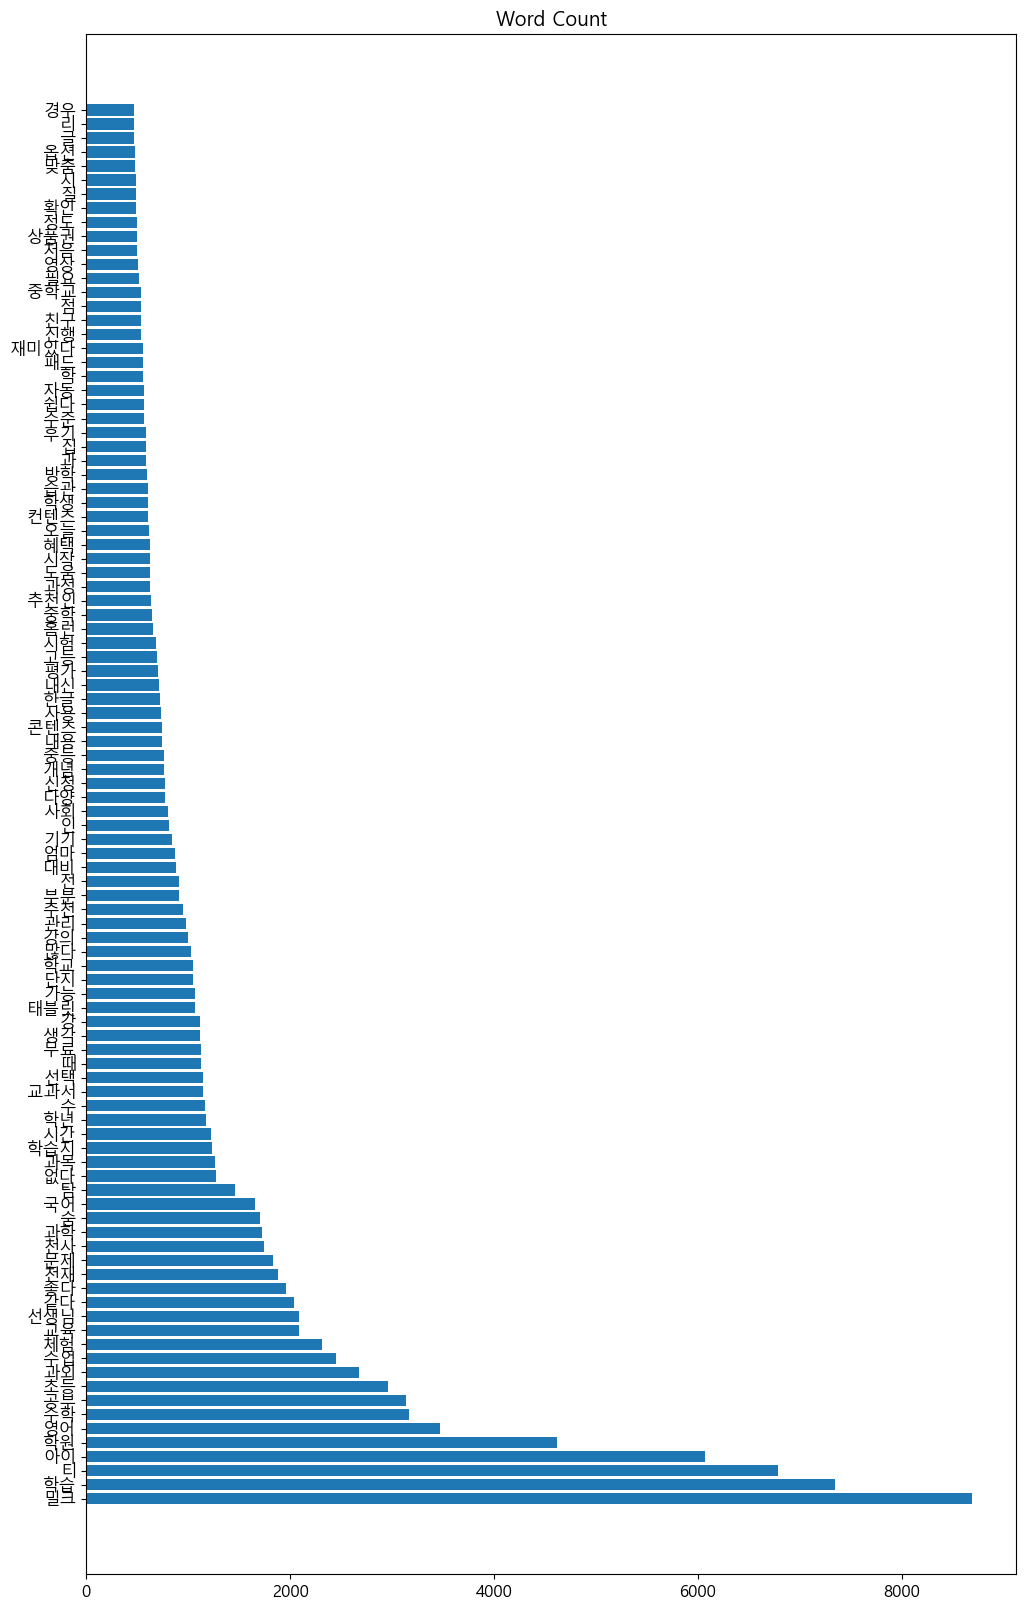

In [8]:
plt.rcParams['font.size'] = 12

y_pos = np.arange(len(top_milk_nouns))

plt.figure(figsize=(12, 20))
plt.barh(y_pos, top_milk_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_milk_nouns.keys())
plt.show()

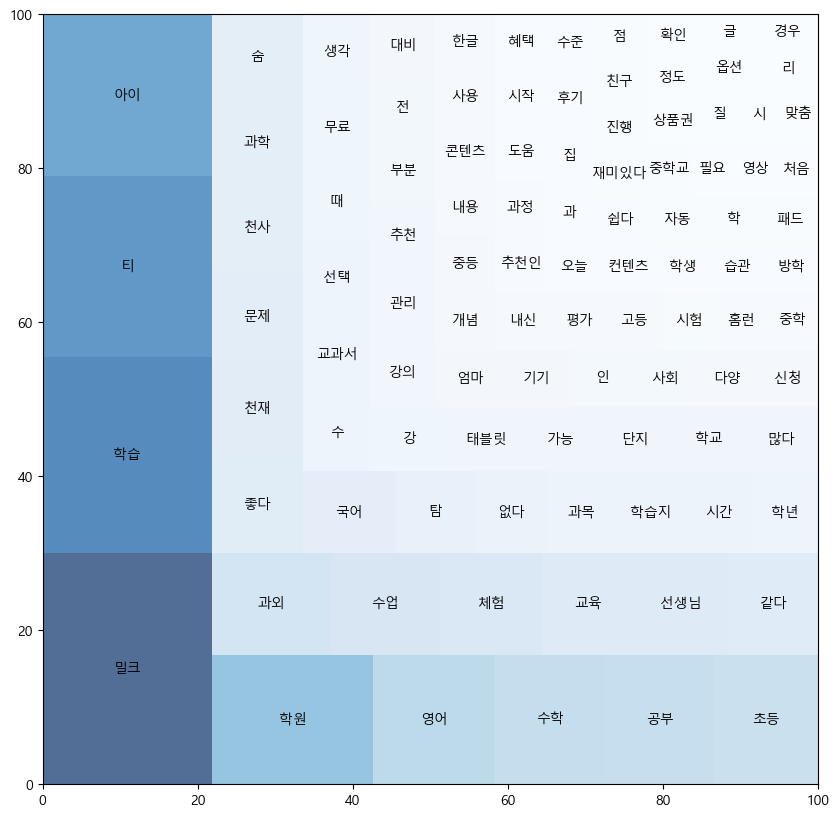

In [9]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 10

norm = mpl.colors.Normalize(vmin = min(top_milk_nouns.values()),
                            vmax = max(top_milk_nouns.values()))

colors = [mpl.cm.Blues(norm(value)) for value in top_milk_nouns.values()]

squarify.plot(label=top_milk_nouns.keys(),
              sizes=top_milk_nouns.values(),
              color=colors,
              alpha=.7);

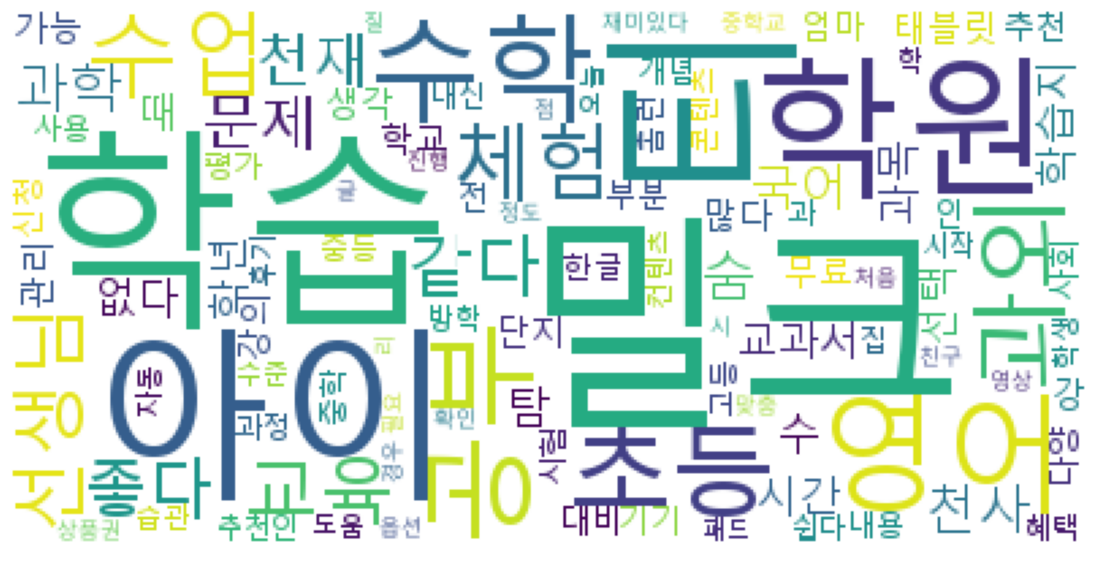

In [10]:
wc = WordCloud(background_color='white', font_path='C:/Windows/Fonts/malgun.ttf')
wc.generate_from_frequencies(top_milk_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

----------------

### 연습장
- 연습장은 여기가 아니라서 여따가 쓰면 안되는데 ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ

In [11]:
# milk_list
# homerun_list

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [12]:
df_mg

,keyword_dict,contents,recommend,아이스크림,엘리하이
0,{'밀크': [' 밀크T는 로그인이 홈런보다는복잡한 편인데요 로그인학습기를 켜면 밀...,아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...,False,True,True
1,{'밀크': [' 아하밀크T는 하단에 오늘의 퀴즈 오늘의 한자가 따로 있어서 함께 ...,우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...,True,True,True
2,{'밀크': [' 이렇게 신청한 스마트 패드가5가지 교원 빨간펜 아이캔두 초등 천재...,곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...,False,True,True
3,{'밀크': [' 전업주부니까 그게 저의 직업이라고 생각했어요하지만 모든걸잘하고 싶...,안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...,False,True,True
4,{'밀크': [' 구분엘리하이7일윙크6일밀크T10일아이스크림 홈럼10일업체메가스터디...,앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...,True,True,True
...,...,...,...,...,...
1006,{'밀크': [' 밀크티는 정액제라 대부분의 강의를 담아서 공부할있어요 물론 너무 ...,중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...,False,False,False
1007,{'밀크': [' ㅜㅜ조금고학년이면 좋아할있을지 모르겠지만현재엘리 하이 아이스크림 ...,홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...,False,True,True
1008,{'밀크': [' 그런데 밀크티에 있는 영상은 추가로 보여주거든요이 영상은 오늘의 ...,작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...,False,False,False
1009,{'밀크': [' 밀크티는 온라인강의지만11 전담 관리선생님이 계셔서학습 스케줄 관...,요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...,False,False,False


In [13]:
milk_list

['밀크',
 '로그',
 '인',
 '홈런',
 '로그',
 '인',
 '학습',
 '기',
 '밀크',
 '티',
 '소리',
 '기',
 '때',
 '소리',
 '바탕',
 '화면',
 '저렇다',
 '초등',
 '콘텐츠',
 '많다',
 '사고력',
 '수학',
 '콘텐츠',
 '심화',
 '학교',
 '수업',
 '다수',
 '좋다',
 '고요',
 '콘텐츠',
 '많다',
 '많다',
 '제가',
 '콘텐츠',
 '힘들다',
 '밀크',
 '일주일',
 '체험',
 '때쯤',
 '아이스크림',
 '홈런',
 '신청',
 '포장',
 '박스',
 '기기',
 '홈런',
 '예쁘다',
 '서비스',
 '주',
 '같다',
 '없다',
 '기계',
 '손잡이',
 '이동',
 '편리',
 '첫인상',
 '홈런',
 '좋다',
 '밀크',
 '로그',
 '인은',
 '홈런',
 '편리',
 '콘텐츠',
 '밀크',
 '티',
 '한눈',
 '좋다',
 '입장',
 '정돈',
 '느낌',
 '콘텐츠',
 '쉽다',
 '밀크',
 '콘텐츠',
 '적지',
 '부분',
 '문제',
 '같다',
 '밀크',
 '삼성',
 '기기',
 '사용',
 '홈런',
 '홈런',
 '자체',
 '기기',
 '인',
 '같다',
 '밀크',
 '키보드',
 '판',
 '이동',
 '손잡이',
 '없다',
 '불편',
 '밀크',
 '펜',
 '작다',
 '감',
 '체험',
 '나중',
 '정회원',
 '기기',
 '펜',
 '홈런',
 '펜',
 '만큼',
 '크기',
 '크다',
 '색상',
 '블랙',
 '밀크',
 '아이',
 '홈런',
 '좋다',
 '밀크',
 '좋다',
 '선택',
 '이유',
 '사실',
 '콘텐츠',
 '자체',
 '부분',
 '선택',
 '밀크',
 '친구',
 '추천',
 '이벤트',
 '추천',
 '분과',
 '추천',
 '상품권',
 '만원',
 '제공',
 '비용',
 '지금',
 '이벤트',
 '밀크',
 '밀크',
 '약정',
 '

In [14]:
text = df_mg['keyword_dict'][0]['밀크'][:1]
text

array([' 밀크T는 로그인이 홈런보다는복잡한 편인데요 로그인학습기를 켜면 밀크티하고소리가 나오는데 저는 기기를때마다소리가 거슬렸다는 ㅎㅎ바탕화면이 저렇게 나오는데 저는 초등으로 들어갔어요 콘텐츠는 굉장히 많았는데요 사고력수학이라는 콘텐츠가 있어서 조금심화해서 학교수업을 들여다수 있어 좋더라고요 외에도 정말 콘텐츠가 많습니다 솔직히 너무 많아서 저는제가 봤던 콘텐츠가 어디있었나 다시 찾기가 힘들었어요'],
      dtype=object)

### TF-IDF

In [23]:
contents_list = []

for i in df_mg['contents']:
    x = re.sub('[ㄱ-ㅎ]+', '', i)
    if not x == '':
        if len(x) != 1 and x[0] != x[1]:
            contents_list.append(x)
    else:
        continue

In [18]:
df_mg['contents']

0       아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...
1       우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...
2       곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...
3       안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...
4       앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...
                              ...                        
1006    중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...
1007    홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...
1008    작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...
1009    요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...
1010    벌써 3월이 끝나가네요. 교복을 어색해하던 게엊그제 같은데 이젠 제법 중학생 티가 ...
Name: contents, Length: 1011, dtype: object

In [22]:
len(contents_list)

1006

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words).fit(text)

print(tfidf.transform(milk_list).toarray())
print(tfidf.vocabulary_)
# value sort
print({k: v for k, v in sorted(tfidf.vocabulary_.items(), key=lambda item: item[1])})

In [ ]:
milk_list.sort()
test_list = []

for i in milk_list:
    x = re.sub('[ㄱ-ㅎ]+', '', i)
    if not x == '':
        if len(x) != 1 and x[0] != x[1]:
            test_list.append(x)
    else:
        continue

In [ ]:
test_list

In [ ]:
len(test_list)

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words).fit(test_list[:2000])

print(tfidf.transform(test_list[:2000]).toarray())
print(tfidf.vocabulary_)
# value sort
# print({k: v for k, v in sorted(tfidf.vocabulary_.items(), key=lambda item: item[1])})

In [ ]:
columns = []
for k, v in sorted(tfidf.vocabulary_.items(), key=lambda item:item[1]):
  columns.append(k)

df = pd.DataFrame(tfidf.transform(test_list).toarray(), columns=columns)
df

In [ ]:
A = list(df.columns)

In [ ]:
f = open("words.txt", 'w')

In [ ]:
for i in A:
    i = i + '\n'
    f.write(i)

f.close

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.05, max_df=0.85)
tfidf_vectors = tfidf.fit_transform(df_mg['contents'])

word_id_list = sorted(tfidf.vocabulary_.items(), key=lambda x: x[1], reverse=False)
word_list = [x[0] for x in word_id_list]

tf_idf_df = pd.DataFrame(tfidf_vectors.toarray(),
                         columns=word_list,
                         index=df_mg['contents'])

# tf_idf_df

In [ ]:
tfidf_vectors

In [ ]:
from sklearn.cluster import DBSCAN

# epsilon 보통 0.5...?!
dbscan = DBSCAN(eps=0.7, min_samples=3, metric='cosine')
dbscan_label = dbscan.fit_predict(tfidf_vectors)
print(dbscan_label)

In [33]:
clus_df = df_mg.copy()
clus_df.drop(columns=['keyword_dict', 'recommend', '아이스크림', '엘리하이'], inplace=True)
clus_df

,contents
0,아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...
1,우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...
2,곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...
3,안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...
4,앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...
...,...
1006,중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...
1007,홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...
1008,작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...
1009,요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...


In [ ]:
clus_df['cluster'] = dbscan_label
clus_df.head()

In [ ]:
clus_df[clus_df['cluster'] == 4]

In [ ]:
### cluster

for cluster_num in set(dbscan_label):
  print('Cluster: {}'.format(cluster_num))
  df = clus_df[clus_df['cluster'] == cluster_num]
  for filename in df['contents']:
    print(filename)
  print()

In [ ]:
!pip install sklearn

In [ ]:
tfidf_vectors.dtype

낼 와서 NLP에 일단 넣어보기

NLP

-------------------------------------------

In [ ]:
!pip install pyLDAvis

In [ ]:
from gensim import corpora
import gensim
import pyLDAvis.gensim_models
from collections import Counter

In [ ]:
df_mg

In [ ]:
df_mg.info()

In [ ]:
df_mg['keyword_dict'][0]['밀크'][0]

In [ ]:
milk_list

In [ ]:
from nltk import word_tokenize

In [ ]:
def preprocess_text(text):

    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w in stop_words]
    text = ' '.join(tokens)
    text = text.lower().strip()

    return text

In [ ]:
preprocess_text(df_mg['keyword_dict'][0]['밀크'][0])

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df_mg['contents'])

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
import numpy as np
np.__version__

In [ ]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
predict = ward.fit_predict(tfidf_vectors.toarray())
predict

In [ ]:
!pip install --upgrade threadpoolctl

In [ ]:
from sklearn.cluster import KMeans

for k in range(2,7):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=42)
    kmeans_label = kmeans.fit_predict(tfidf_vectors)
    kmeans_centers = kmeans.cluster_centers_

    print(kmeans_label)
    pd.DataFrame(kmeans_centers)

In [34]:
df = clus_df.copy()
df

,contents
0,아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...
1,우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...
2,곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...
3,안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...
4,앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...
...,...
1006,중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...
1007,홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...
1008,작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...
1009,요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...


In [35]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), min_df=0.05, max_df=0.85) # stop_words : 임시로 만든 불용어 사전

tfidf_vectors = tfidf.fit_transform(df['contents']) # contents : 본문 (str) / df : column은 본문(col_name = contents)만 있는 상태입니다.

# K-means 알고리즘
# 노이즈데이터에 취약...
from sklearn.cluster import KMeans

# cluster수를 1~10에서 for문 혹은 지정하여 진행해 봤습니다.
# k = range(1:10)
# for k in k:
k = 3
kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=42)
kmeans_label = kmeans.fit_predict(tfidf_vectors)
kmeans_centers = kmeans.cluster_centers_

print(kmeans_label)
pd.DataFrame(kmeans_centers)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 1 ... 1 1 1]


,0,1,2,3,4,5,6,7,8,9,...,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268
0,0.000000,0.000000,0.039623,0.039623,0.000000,0.039623,0.039623,0.039623,0.027155,0.039058,...,0.000753,0.000000,0.039826,0.040168,0.032949,0.039623,0.000000,0.002856,0.002359,0.000000
1,0.008511,0.016872,0.000000,0.000000,0.007499,0.000000,0.000000,0.000000,0.000000,0.000341,...,0.008271,0.005049,0.000240,0.000000,0.005184,0.000000,0.005232,0.004819,0.007480,0.019594
2,0.006380,0.007916,0.000000,0.000000,0.017103,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006104,0.018710,0.000000,0.000000,0.016836,0.000000,0.006473,0.005360,0.002324,0.006166


In [ ]:
clus_df

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(tfidf_vectors.toarray())
clus_df['x0'] = pca_vecs[:, 0]
clus_df['x1'] = pca_vecs[:, 1]

cluster_map = {0: '밀크티_리뷰', 2:'광고', -1:'밀크티_언급'}
clus_df['cluster'] = clus_df['contents'].map(cluster_map)

clus_df.head()

In [ ]:
clus_df['contents'].map(cluster_map)

In [ ]:
results = df_mg.copy()
results['predict'] = predict
results[results['predict'] == 1]

In [ ]:
tf_idf_df

In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cos_sim_df = pd.DataFrame(cosine_similarity(tf_idf_df, tf_idf_df),
                          columns=clus_df['contents'],
                          index=clus_df['contents'])

In [ ]:
clus_df

In [ ]:
milk_indexes = clus_df[clus_df['cluster'] == 0].index
print(milk_indexes)

milk_file_name = clus_df.iloc[milk_indexes[0]]['contents']
print(milk_file_name)

similarity = cosine_similarity(tfidf_vectors[milk_indexes[0]], tfidf_vectors[milk_indexes])
print(similarity)

In [ ]:
sorted_index = similarity.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]
print(sorted_index)

milk_sorted_indexes = milk_indexes[sorted_index.reshape(-1)]
print(milk_sorted_indexes)

milk_1_similarity = np.sqrt(similarity.reshape(-1)[::-1])
milk_1_similarity = milk_1_similarity[1:]
print(milk_1_similarity)

In [ ]:
df_simil = pd.DataFrame({'similarity': milk_1_similarity},
                   index=clus_df.iloc[milk_sorted_indexes]['contents'])

In [ ]:
df_simil.columns

코드파일 정리필요...
Kmeans 왜 안될까...

-------------

## 계층적 군집화
- 병합 군집화 : `agglomerativeClustering`

In [ ]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
predict = ward.fit_predict(tfidf_vectors.toarray())
predict

In [ ]:
def cluster_milk(num):
    if num == -1:
        num = 'Free'
    elif num == 0 or num == 1:
        num = 'MilkT'
    elif num == 2 or num == 3 or num == 4:
        num = 'AD'
    return num

clus_df['cluster'] = clus_df['cluster'].apply(lambda x : cluster_milk(x))
clus_df

In [ ]:
results = clus_df.copy()
results['predict'] = predict
results[:10]

In [ ]:
sns.scatterplot(x='x0', y='x1', data=results, hue='predict', palette='viridis');

avg : 클러스터간 평균 거리가 짧은 두 클러스터 합쳐버리기~

In [ ]:
avg = AgglomerativeClustering(n_clusters=3, linkage='average')
predict = avg.fit_predict(tfidf_vectors.toarray())
predict

In [ ]:
results = clus_df.copy()
results['predict'] = predict
results[:10]

In [ ]:
sns.scatterplot(x='x0', y='x1', data=results, hue='predict', palette='viridis');

complete : 클러스터 간 최대거리가 가장 짧은 두 클러스터 합치기~

In [ ]:
complt = AgglomerativeClustering(n_clusters=3, linkage='complete')
predict = complt.fit_predict(tfidf_vectors.toarray())
predict

In [ ]:
results = clus_df.copy()
results['predict'] = predict
results[:10]

In [ ]:
sns.scatterplot(x='x0', y='x1', data=results, hue='predict', palette='viridis');

### 덴드로그램
- `pdist`를 이용한 각 단어간 유클리디안 거리 계산

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

distmatrix = pdist(tfidf_vectors.toarray(), metric='euclidean')
row_dist = pd.DataFrame(squareform(distmatrix))
row_dist

In [ ]:
row_clusters = linkage(distmatrix, method='complete')

plt.figure(figsize=(20,10))
dendrogram(row_clusters,
           leaf_rotation=50,
           leaf_font_size=10)
plt.show() # 쓰나미다~

### TM_W2V

In [ ]:
!pip install gensim

In [ ]:
milk_nouns = Kkma.nouns(df_mg.contents[0])

In [ ]:
milk_nouns = test_list.copy()

In [ ]:
import gensim

milk_bigram = gensim.models.Phrases(milk_nouns)
milk_trigram = gensim.models.Phrases(milk_bigram[milk_nouns])
milk_bigram_model = gensim.models.phrases.Phraser(milk_bigram)
milk_trigram_model = gensim.models.phrases.Phraser(milk_trigram)

In [ ]:
milk_nouns

In [ ]:
milk_bigram_model[milk_nouns]

In [ ]:
from gensim import corpora
milk_bigram_document = [milk_bigram_model[nouns] for nouns in milk_nouns]
milk_bigram_document[2]

In [ ]:
milk_id2word = corpora.Dictionary(milk_bigram_document)
milk_corpus = [milk_id2word.doc2bow(doc) for doc in milk_bigram_document]
milk_corpus[0]

In [ ]:
from gensim.models import CoherenceModel

In [ ]:
milk_coherence_score=[]
for i in range(2,10):
    model = gensim.models.ldamodel.LdaModel(corpus=milk_corpus, id2word=milk_id2word, num_topics=i)
    coherence_model = CoherenceModel(model, texts=milk_bigram_document, dictionary=milk_id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    print('n=',i,'\nCoherence Score: ', coherence_lda)
    milk_coherence_score.append(coherence_lda)